[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
<ipython-input-2-255558d28079>:31: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  var_estimates[0] = np.var(returns)
<ipython-input-2-255558d28079>:33: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  var_estimates[t] = lmb * var_estimates[t - 1] + (1 - lmb) * returns.iloc[t - 1]**2


Optimal EWMA Lambda: 0.9999999999999665


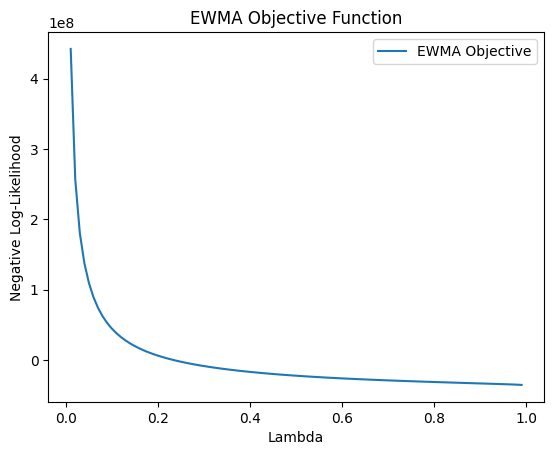

<ipython-input-2-255558d28079>:73: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  var_estimates[0] = np.var(returns)
<ipython-input-2-255558d28079>:75: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  var_estimates[t] = (


Optimal GARCH(1,1) Parameters: [3.11832752e-04 1.82294498e-08 1.65385344e-03]


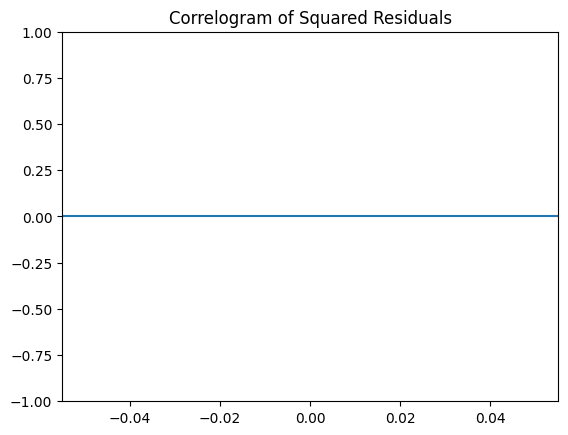

In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
from scipy import optimize
import matplotlib.pyplot as plt


# Part 1 - Returns Function
def yf_daily_log_returns(ticker_symbol: str, start_date: str, end_date: str) -> pd.Series:
    """Pulls Yahoo! Finance data and calculates daily log returns."""
    data = yf.download(ticker_symbol, start=start_date, end=end_date)['Adj Close']
    returns = np.log(data / data.shift(1)).dropna()
    return returns


# Part 2 - Log Likelihood Function
def gaussian_ll(returns: pd.Series, vars: pd.Series) -> float:
    """Conditional Gaussian log likelihood function."""
    n = len(returns)
    # Ensure vars is a pandas Series and its values are used for calculation
    # Change: Access the values of the returns Series using .values
    ll = -0.5 * np.sum(np.log(2 * np.pi * vars.values) + (returns.values**2) / vars.values)
    return ll


# Part 3 - EWMA Variance Estimates
def ewma_var_estimates(lmb: float, returns: pd.Series) -> pd.Series:
    """Generates EWMA variance estimates for a given lambda."""
    assert returns.index.is_monotonic_increasing, "Returns must be in ascending order!"
    var_estimates = np.zeros(len(returns))
    var_estimates[0] = np.var(returns)
    for t in range(1, len(returns)):
        var_estimates[t] = lmb * var_estimates[t - 1] + (1 - lmb) * returns.iloc[t - 1]**2
    return pd.Series(var_estimates, index=returns.index)


# Part 4 - EWMA Calibration Objective Function
def ewma_objective(lmb: float, returns: pd.Series) -> float:
    """EWMA objective function to minimize."""
    if not (0 < lmb < 1):
        return np.inf
    vars = ewma_var_estimates(lmb, returns)
    return -gaussian_ll(returns, vars)


# Part 5 - Calibrate EWMA
def ewma_fit(returns: pd.Series, guess: float = 0.9) -> float:
    """Fits an EWMA model to returns using Gaussian conditional log-likelihood."""
    result = optimize.minimize(
        ewma_objective, x0=guess, args=(returns,), method='Nelder-Mead', tol=1e-15
    )
    return result.x[0]


# Part 6 - Plot the EWMA Objective Function
def plot_ewma_objective(returns: pd.Series):
    """Plots the EWMA objective function."""
    lambdas = np.linspace(0.01, 0.99, 100)
    objectives = [ewma_objective(lmb, returns) for lmb in lambdas]
    plt.plot(lambdas, objectives, label="EWMA Objective")
    plt.xlabel("Lambda")
    plt.ylabel("Negative Log-Likelihood")
    plt.title("EWMA Objective Function")
    plt.legend()
    plt.show()


# Part 7 - GARCH(1,1) Variance Estimates
def garch11_var_estimates(a0: float, a1: float, b1: float, returns: pd.Series) -> pd.Series:
    """Generates GARCH(1,1) variance estimates."""
    assert returns.index.is_monotonic_increasing, "Returns must be in ascending order!"
    var_estimates = np.zeros(len(returns))
    var_estimates[0] = np.var(returns)
    for t in range(1, len(returns)):
        var_estimates[t] = (
            a0 + a1 * returns.iloc[t - 1]**2 + b1 * var_estimates[t - 1]
        )
    return pd.Series(var_estimates, index=returns.index)


# Part 8 - GARCH Calibration Objective Function
def garch11_objective(params: tuple[float, float, float], returns: pd.Series) -> float:
    """GARCH(1,1) objective function."""
    a0, a1, b1 = params
    if not (a0 > 0 and 0 <= a1 <= 1 and 0 <= b1 <= 1 and a1 + b1 < 1):
        return np.inf
    vars = garch11_var_estimates(a0, a1, b1, returns)
    return -gaussian_ll(returns, vars)


# Part 9 - Calibrate GARCH(1,1)
def garch11_fit(
    returns: pd.Series, guess: tuple[float, float, float] = (0.0001, 0.1, 0.8)
) -> tuple[float, float, float]:
    """Fits GARCH(1,1) model to returns using Gaussian log-likelihood."""
    result = optimize.minimize(
        garch11_objective, x0=guess, args=(returns,), method='Nelder-Mead', tol=1e-15
    )
    return result.x


# Part 10 - Plot Correlograms
def plot_correlogram(data: pd.Series, lags: int = 20, title: str = "Correlogram"):
    """Plots autocorrelation for a given series."""
    from statsmodels.graphics.tsaplots import plot_acf

    if isinstance(data, pd.DataFrame):
        data = data.iloc[:, 0]

    plot_acf(data, lags=lags)
    plt.title(title)
    plt.show()


# Example Usage (Test Code)
if __name__ == "__main__":
    # Example: Download data and compute returns
    ticker = "AAPL"
    start = "2010-01-01"
    end = "2024-10-01"
    returns = yf_daily_log_returns(ticker, start, end)

    # EWMA Calibration
    ewma_lambda = ewma_fit(returns)
    print(f"Optimal EWMA Lambda: {ewma_lambda}")
    plot_ewma_objective(returns)

    # GARCH Calibration
    garch_params = garch11_fit(returns)
    print(f"Optimal GARCH(1,1) Parameters: {garch_params}")
    standardized_residuals = returns / np.sqrt(
        garch11_var_estimates(*garch_params, returns)
    )
    plot_correlogram(standardized_residuals**2, title="Correlogram of Squared Residuals")
